In [6]:
%load_ext autoreload
%autoreload 2
import pylab as plt
import torch
import numpy as np
from tqdm.auto import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Nested sampling Class

In [7]:
class SwyftSimpleSliceSampler:
    def __init__(self, X_init):
        self.X_init = X_init
        self.X_live = X_init*1.
        self.L_live = None

    @staticmethod
    def _get_directions(B, D):
        """This function generates a minibatch of D-dimensional random directions."""
        t = torch.randn(B, D)
        l = (t**2).sum(axis=-1)**0.5
        n = t/l.unsqueeze(-1)
        return n

    @staticmethod
    def _get_slice_sample_points(B, S):
        """This function generates a minibatch of S slice sample positions."""
        hard_bounds = torch.tensor([-1., 1.]).unsqueeze(0).repeat((B,1))
        current_bounds = hard_bounds.clone()
        L = torch.empty((B, S))
        for i in range(S):
            x = torch.rand(B)*(current_bounds[:,1]-current_bounds[:,0])+current_bounds[:,0]
            L[:,i] = x
            current_bounds[x<0,0] = x[x<0]
            current_bounds[x>0,1] = x[x>0]
        return L
    
    def _gen_new_samples(self, X_seeds, logl_fn, logl_th, num_steps = 10, max_step_size = 1., samples_per_slice = 20):
        """This function generates new samples within the likelihodo constraint logl_fn > log_th."""
        B, D = X_seeds.shape
        C = torch.zeros(B)  # counter for accepted points
        X = X_seeds.clone()
        logl = torch.ones(B)*(-np.inf)
        for i in range(num_steps):
            N = self._get_directions(B, D)
            L = self._get_slice_sample_points(B, S = samples_per_slice)*max_step_size
            dX = N.unsqueeze(-2)*L.unsqueeze(-1)
            pX = X.unsqueeze(-2) + dX # proposals
            logl_prop = logl_fn(pX)
            accept_matrix = logl_prop > logl_th
            idx = torch.argmax(accept_matrix.int(), dim=1)
            nX = torch.stack([pX[i][idx[i]] for i in range(B)], dim=0)
            logl_selected = torch.stack([logl_prop[i][idx[i]] for i in range(B)], dim=0)
            accept_any = (accept_matrix.sum(dim=-1)>0)
            X[accept_any] = nX[accept_any]
            logl[accept_any] = logl_selected[accept_any]
            C[accept_any] += 1
        return X[C==num_steps], logl[C==num_steps]
    
    def nested_sampling(self, logl_fn, logl_th_max = np.inf, max_steps = 100000, num_batch_samples = 100, epsilon = 1e-6):
        """Run nested sampling, staring with X_init live points."""
        X_init = self.X_live
        NLP, D = X_init.shape
        X_live = X_init.clone()
        if self.L_live is None:
            L_live = logl_fn(X_live)
        else:
            L_live = self.L_live
        B = min(num_batch_samples, NLP)  # Number of samples generated simultanously
        V = 1.  # initial volume is set to 1.
        samples_X = []
        samples_logl = []  # logl values
        samples_logv = []  # estimate of constrained volume
        samples_Z = []
        samples_logwt = []
        logl_th = -np.inf
        Z = 0
        Z_rest = np.inf

        pbar = tqdm(range(max_steps))
        for i in pbar:
    #        pbar.set_description("logl_min=%.2f, Z=%.2e"%(logl_th, Z))
            pbar.set_description("Z_sum=%.2e, Z_rest=%.2e, logl_min=%.2f"%(Z, Z_rest, logl_th))
            idx_batch = np.random.choice(range(NLP), B, replace = True)
            X_batch = X_live[idx_batch]
            logl_th = L_live.min()
            if logl_th > logl_th_max:  # Stop sampling once maxmimum threshold is reached
                break
            X_new, L_new = self._gen_new_samples(X_batch, logl_fn, logl_th, num_steps = 10)
            for i in range(len(X_new)):
                if L_new[i] > L_live.min():
                    idx_min = np.argmin(L_live)
                    Lmin = L_live[idx_min].item()*1.
                    samples_X.append(1.*X_live[idx_min].numpy())
                    samples_logl.append(Lmin)
                    samples_logv.append(np.log(V))
                    L_live[idx_min] = L_new[i]*1.0
                    X_live[idx_min] = X_new[i]*1.0
                    V *= (1-1/NLP)  # Volume estimate per sample
                    dZ = V/NLP*np.exp(Lmin)
                    samples_Z.append(dZ)
                    samples_logwt.append(Lmin + np.log(V/NLP))
                    Z = Z + dZ
                    Z_rest = V*torch.exp(L_live.max()*1.)
                    #print(L_live.max()*1.)
                else:
                    break
            if Z_rest < Z*epsilon:
    #            print(Z_rest, Z)
                break
        samples_logv = torch.tensor(np.array(samples_logv)).float()
        samples_logl = torch.tensor(np.array(samples_logl)).float()
        samples_X = torch.tensor(np.array(samples_X)).float()
        samples_logwt = torch.tensor(np.array(samples_logwt)).float()
        self.X_live = X_live
        self.L_live = L_live
        self.samples_X = samples_X
        self.samples_logv = samples_logv
        self.samples_logl = samples_logl
        self.samples_logwt = samples_logwt
        return samples_X, samples_logv, samples_logl, samples_logwt, X_live, L_live

    def grow_live_points(self, logl_fn, logl_th_max = -1.0, num_batch_samples = 100, num_samples = 10000):
        X_init = self.X_live
        NLP, D = X_init.shape
        X_live = X_init.clone()
        L_live = logl_fn(X_live)
        B = min(num_batch_samples, NLP)  # Number of samples generated simultanously
        while len(X_live) < num_samples:
            NLP = len(X_live)
            idx_batch = np.random.choice(range(NLP), B, replace = True)
            X_batch = X_live[idx_batch]
            X_new, L_new = self._gen_new_samples(X_batch, logl, logl_th_max, num_steps = 10)
            X_live = torch.cat([X_live, X_new])
            L_live = torch.cat([L_live, L_new])
        return X_live, L_live
    
    def get_threshold(self, p):
    #    logwt = samples_logl[1:]+np.log(samples_logv[:-1]-samples_logv[1:])
        wt = np.exp(self.samples_logwt)
        wt /= wt.sum()
        cwt = np.cumsum(wt)
        return np.interp(p, cwt, self.samples_logl)

    def get_posterior_samples(self, N = None):
        if N is None:
            N = int(self.get_posterior_neff())
        logwt = self.samples_logwt
        wt = torch.exp(logwt - logwt.max())
        wt = torch.tensor(wt)
        wt /= wt.sum()
        idx = torch.multinomial(wt, N, replacement = True)
        return self.samples_X[idx], self.samples_logl[idx]

    def get_posterior_neff(self):
        logwt = self.samples_logwt
        wt = torch.exp(logwt - logwt.max())
        wt = torch.tensor(wt)
        wt /= wt.sum()
        n_eff = sum(wt)**2/sum(wt**2)
        return n_eff.item()
    
    def get_constrained_prior_samples(self, N = None, min_logl = -np.inf):
        if N is None:
            N = int(self.get_constrained_prior_neff(min_logl))
        logv = self.samples_logv
        logl = self.samples_logl
        mask = logl >= min_logl
        wt = torch.exp(logv[mask]-logv[mask].max())
        idx = torch.multinomial(wt, N, replacement = True)
        return self.samples_X[mask][idx], self.samples_logl[mask][idx]
    
    def get_constrained_prior_neff(self, min_logl):
        logv = self.samples_logv
        logl = self.samples_logl
        mask = logl >= min_logl
        wt = torch.exp(logv[mask]-logv[mask].max())
        n_eff = sum(wt)**2/sum(wt**2)
        return n_eff.item()

### Plotting live points

In [8]:
def logl_model(u):
    ret = -(0.5*(u[..., :]**2)/0.1**2).sum(axis=-1)**1.0
    return ret

In [17]:
# Initial run to explore likelihood and determine threshold of typical set
X_init = torch.randn(100, 20)
s4 = SwyftSimpleSliceSampler(X_init)
s4.nested_sampling(logl_model, logl_th_max = -.0, num_batch_samples = 50, epsilon = 1e-3);
min_logl = s4.get_threshold(1e-6)
print("Threshold: min_log =", min_logl)

# Second run above threshold to sample posterior
X_init2, _ = s4.get_constrained_prior_samples(1000, min_logl);
s5 = SwyftSimpleSliceSampler(X_init2)
s5.nested_sampling(logl_model, epsilon = 1e-3)
print("Number of actual and effective posterior samples:", len(s5.samples_X), int(s5.get_posterior_neff()))

  0%|          | 0/100000 [00:00<?, ?it/s]

Threshold: min_log = -33.41403767095502


  0%|          | 0/100000 [00:00<?, ?it/s]

Number of actual and effective posterior samples: 26263 11242


/var/folders/xy/7m07k3417w76kc7zq5jpq3500000gn/T/ipykernel_21465/4253490133.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wt = torch.tensor(wt)


/var/folders/xy/7m07k3417w76kc7zq5jpq3500000gn/T/ipykernel_21465/4253490133.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wt = torch.tensor(wt)
/var/folders/xy/7m07k3417w76kc7zq5jpq3500000gn/T/ipykernel_21465/4253490133.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wt = torch.tensor(wt)


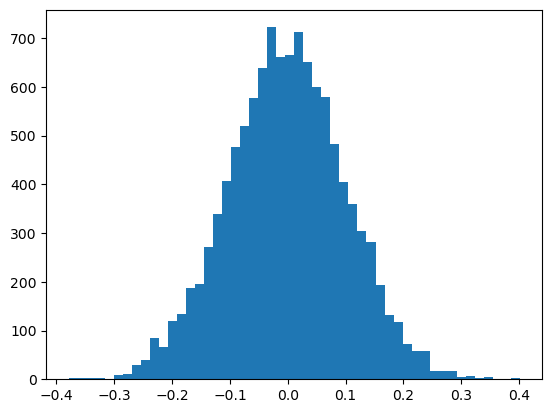

In [18]:
X1, _ = s5.get_posterior_samples()
#plt.scatter(X1[:,0], X1[:,1], marker='.')
plt.hist(X1[:,0], bins = 50);

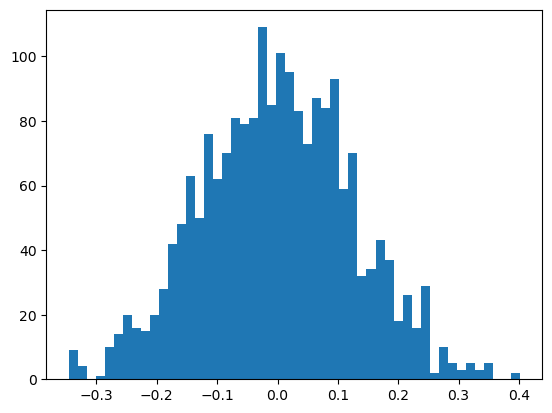

In [19]:
X2, _ = s5.get_constrained_prior_samples(min_logl = -18)
#plt.scatter(X2[:,0], X2[:,1], marker = '.')
plt.hist(X2[:,0], bins = 50);

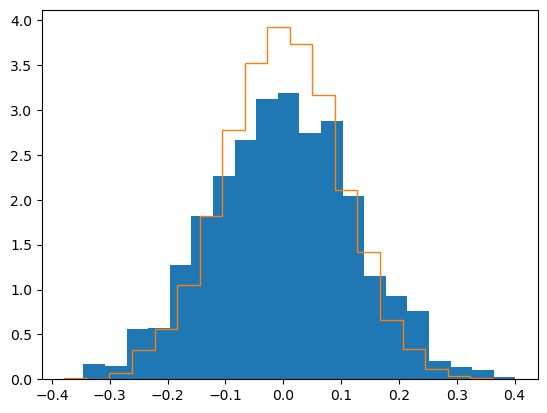

In [21]:
plt.hist(X2[:,0], bins = 20, density = True);
plt.hist(X1[:,0], bins = 20, density = True, histtype = 'step');